In [1]:
import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os


Using TensorFlow backend.


## Load from keras.datasets.cifar10¶

In [6]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

print('train: {}/{}  {}/{}'.format(x_train.shape, y_train.shape, type(x_train), type(y_train)))
print('test: {}/{}  {}/{}'.format(x_test.shape, y_test.shape, type(x_test), type(y_test)))


train: (50000, 32, 32, 3)/(50000, 1)  <class 'numpy.ndarray'>/<class 'numpy.ndarray'>
test: (10000, 32, 32, 3)/(10000, 1)  <class 'numpy.ndarray'>/<class 'numpy.ndarray'>


## Preprocessing

train: (50000, 3072)/(50000, 10)  <class 'numpy.ndarray'>/<class 'numpy.ndarray'>
test: (10000, 3072)/(10000, 10)  <class 'numpy.ndarray'>/<class 'numpy.ndarray'>


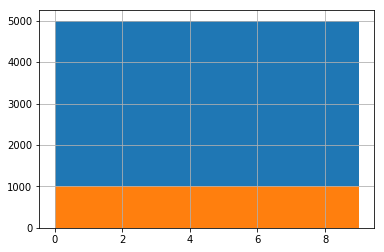

In [7]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)

train_df = pd.DataFrame(x_train)
train_df['label'] = y_train
test_df = pd.DataFrame(x_test)
test_df['label'] = y_test

y_train = label_OHE(y_train)
y_test = label_OHE(y_test)

print('train: {}/{}  {}/{}'.format(x_train.shape, y_train.shape, type(x_train), type(y_train)))
print('test: {}/{}  {}/{}'.format(x_test.shape, y_test.shape, type(x_test), type(y_test)))
train_df.label.hist()
test_df.label.hist()


## Create Model (MLP)

In [8]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, drop=drop_list, reg={'L2':1e-5}):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model


In [9]:
model = build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
                  hidden=h_list, drop=drop_list, reg={'L2':1e-5})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

## Hyperparameter

In [10]:
EPOCHS = 100
LEARNINGRATE = 1e-3
BATCH_SIZE = 256
DROP_RATE_LIST = [0.25, 0.25, 0.25]

## Training

In [11]:
#choose optimizer

optimizer = keras.optimizers.adam(lr=LEARNINGRATE)

def model_training(train = (x_train, y_train), valid = (x_test, y_test),
                   optimizer = optimizer, 
                   e = EPOCHS, bs = BATCH_SIZE, m = model):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, 
              batch_size= bs, epochs=e, shuffle=True)
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    record = {'train_loss':train_loss, 'valid_loss':valid_loss,
              'train_acc':train_acc, 'valid_acc':valid_acc }
    return model, record

In [12]:
model= build_mlp()
optimizer = keras.optimizers.adam(lr=LEARNINGRATE)
model, record = model_training(optimizer=optimizer, m = model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 102us/step - loss: 2.0889 - acc: 0.2354 - val_loss: 1.8627 - val_acc: 0.3399
Epoch 2/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8942 - acc: 0.3177 - val_loss: 1.7688 - val_acc: 0.3685
Epoch 3/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.8395 - acc: 0.3378 - val_loss: 1.7310 - val_acc: 0.3805
Epoch 4/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7849 - acc: 0.3570 - val_loss: 1.7144 - val_acc: 0.3866
Epoch 5/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7665 - acc: 0.3651 - val_loss: 1.6730 - val_acc: 0.4043
Epoch 6/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7520 - acc: 0.3725 - val_loss: 1.6580 - val_acc: 0.4179
Epoch 7/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.7208 - acc: 0.3830 - val_loss: 1.6324 -

50000/50000 [==============================] - 2s 31us/step - loss: 1.4757 - acc: 0.4743 - val_loss: 1.4321 - val_acc: 0.4969
Epoch 60/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4666 - acc: 0.4754 - val_loss: 1.4650 - val_acc: 0.4841
Epoch 61/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4630 - acc: 0.4791 - val_loss: 1.4785 - val_acc: 0.4832
Epoch 62/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4702 - acc: 0.4780 - val_loss: 1.4467 - val_acc: 0.4872
Epoch 63/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4847 - acc: 0.4729 - val_loss: 1.4379 - val_acc: 0.4953
Epoch 64/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4638 - acc: 0.4789 - val_loss: 1.4405 - val_acc: 0.4900
Epoch 65/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4728 - acc: 0.4734 - val_loss: 1.4526 - val_acc: 0.4859
Epoch 66/100
50000/50000 [==============

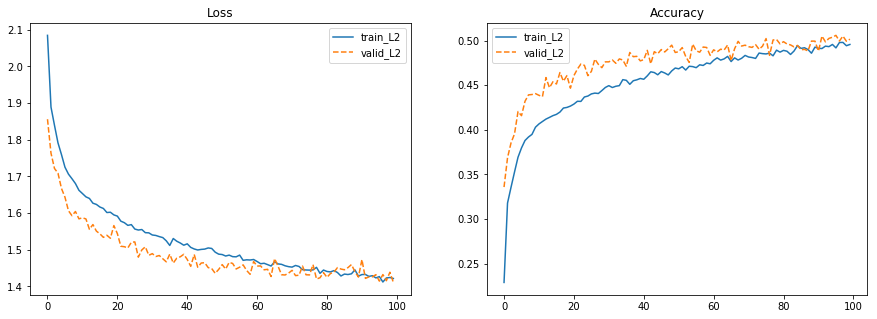

In [15]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()

            
plot_result(record, 'L2', ax1, ax2)
plt.show()

## Dropout_rate Search

In [14]:
dorpout_rate = [0, 0.25, 0.5]
result = {}
for d in dorpout_rate:
    EPOCHS = 100
    LEARNINGRATE = 1e-3
    BATCH_SIZE = 256
    DROP_RATE_LIST = [d]*3
    model= build_mlp()
    optimizer = keras.optimizers.adam(lr=LEARNINGRATE)
    model, record = model_training(optimizer=optimizer, m = model)
    result['drop_'+str(d)] = record

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 47us/step - loss: 2.0896 - acc: 0.2317 - val_loss: 1.8515 - val_acc: 0.3396
Epoch 2/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.9028 - acc: 0.3106 - val_loss: 1.8239 - val_acc: 0.3329
Epoch 3/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8379 - acc: 0.3372 - val_loss: 1.7142 - val_acc: 0.3966
Epoch 4/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7917 - acc: 0.3581 - val_loss: 1.6851 - val_acc: 0.4053
Epoch 5/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7610 - acc: 0.3659 - val_loss: 1.6735 - val_acc: 0.4047
Epoch 6/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7372 - acc: 0.3773 - val_loss: 1.6325 - val_acc: 0.4135
Epoch 7/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7202 - acc: 0.3826 - val_loss: 1.6198 - 

50000/50000 [==============================] - 2s 32us/step - loss: 1.4773 - acc: 0.4725 - val_loss: 1.4452 - val_acc: 0.4960
Epoch 60/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4736 - acc: 0.4749 - val_loss: 1.4393 - val_acc: 0.5028
Epoch 61/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4739 - acc: 0.4759 - val_loss: 1.4374 - val_acc: 0.5064
Epoch 62/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4728 - acc: 0.4757 - val_loss: 1.4962 - val_acc: 0.4787
Epoch 63/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4689 - acc: 0.4775 - val_loss: 1.4680 - val_acc: 0.4917
Epoch 64/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4703 - acc: 0.4746 - val_loss: 1.4556 - val_acc: 0.4905
Epoch 65/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.4757 - acc: 0.4767 - val_loss: 1.4750 - val_acc: 0.4900
Epoch 66/100
50000/50000 [==============

Epoch 18/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6329 - acc: 0.4129 - val_loss: 1.5548 - val_acc: 0.4573
Epoch 19/100
50000/50000 [==============================] - 2s 30us/step - loss: 1.6187 - acc: 0.4179 - val_loss: 1.5404 - val_acc: 0.4545
Epoch 20/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6113 - acc: 0.4214 - val_loss: 1.5539 - val_acc: 0.4452
Epoch 21/100
50000/50000 [==============================] - 2s 30us/step - loss: 1.6082 - acc: 0.4213 - val_loss: 1.5429 - val_acc: 0.4591
Epoch 22/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6036 - acc: 0.4239 - val_loss: 1.5285 - val_acc: 0.4653
Epoch 23/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5994 - acc: 0.4244 - val_loss: 1.5348 - val_acc: 0.4556
Epoch 24/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5928 - acc: 0.4270 - val_loss: 1.5469 - val_acc: 0.4504
Epoch 25/100
50000/50000 [=

Epoch 77/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4893 - acc: 0.4689 - val_loss: 1.4641 - val_acc: 0.4903
Epoch 78/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4805 - acc: 0.4726 - val_loss: 1.4593 - val_acc: 0.4866
Epoch 79/100
50000/50000 [==============================] - 2s 30us/step - loss: 1.4910 - acc: 0.4687 - val_loss: 1.4613 - val_acc: 0.4936
Epoch 80/100
50000/50000 [==============================] - 2s 30us/step - loss: 1.4763 - acc: 0.4753 - val_loss: 1.4623 - val_acc: 0.4811
Epoch 81/100
50000/50000 [==============================] - 2s 30us/step - loss: 1.4790 - acc: 0.4727 - val_loss: 1.4401 - val_acc: 0.4952
Epoch 82/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4766 - acc: 0.4741 - val_loss: 1.4553 - val_acc: 0.4946
Epoch 83/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4795 - acc: 0.4740 - val_loss: 1.4608 - val_acc: 0.4836
Epoch 84/100
50000/50000 [=

50000/50000 [==============================] - 2s 31us/step - loss: 1.5240 - acc: 0.4563 - val_loss: 1.4667 - val_acc: 0.4783
Epoch 36/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5114 - acc: 0.4555 - val_loss: 1.4877 - val_acc: 0.4712
Epoch 37/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5303 - acc: 0.4510 - val_loss: 1.4633 - val_acc: 0.4867
Epoch 38/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5230 - acc: 0.4551 - val_loss: 1.4768 - val_acc: 0.4820
Epoch 39/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5181 - acc: 0.4561 - val_loss: 1.4805 - val_acc: 0.4824
Epoch 40/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5121 - acc: 0.4576 - val_loss: 1.4872 - val_acc: 0.4773
Epoch 41/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5159 - acc: 0.4567 - val_loss: 1.4733 - val_acc: 0.4787
Epoch 42/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.4289 - acc: 0.4933 - val_loss: 1.4258 - val_acc: 0.5025
Epoch 95/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4229 - acc: 0.4957 - val_loss: 1.4318 - val_acc: 0.5038
Epoch 96/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4265 - acc: 0.4919 - val_loss: 1.4141 - val_acc: 0.5059
Epoch 97/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4117 - acc: 0.4979 - val_loss: 1.4320 - val_acc: 0.4995
Epoch 98/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4228 - acc: 0.4980 - val_loss: 1.4153 - val_acc: 0.5051
Epoch 99/100
50000/50000 [==============================] - 2s 30us/step - loss: 1.4240 - acc: 0.4943 - val_loss: 1.4383 - val_acc: 0.4993
Epoch 100/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4213 - acc: 0.4957 - val_loss: 1.4105 - val_acc: 0.5016


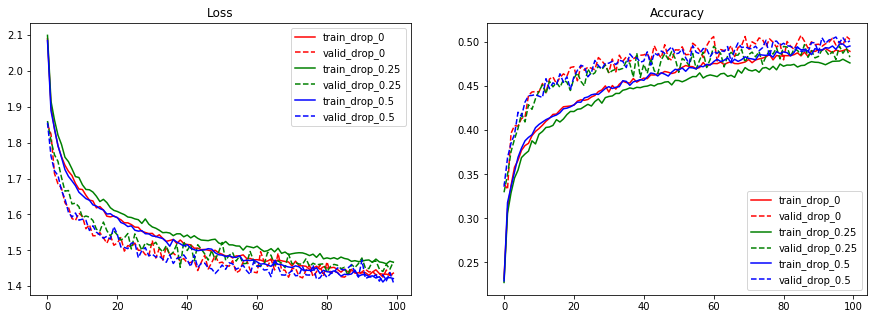

In [31]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
color = ['r', 'g', 'b']
for idx, k in enumerate(result.keys()):
    for idx2, kk in enumerate(result[k].keys()):
        if kk[0] == 't':
            L, c, line= 'train_' + k, color[idx], '-' 
        else:
            L, c, line = 'valid_' + k, color[idx], '--'
        
        if kk[-4:] == 'loss':
            ax1.plot(range(len(result[k][kk])), result[k][kk], line, label=L, color = c)
        else:
            ax2.plot(range(len(result[k][kk])), result[k][kk], line, label=L, color = c)
        ax1.legend()
        ax2.legend()
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
